In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

## Optimizing using GD and artificial data

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [3]:
def utility_function_grad(r_p, gamma, r_p_grad):
    u_grad = np.power((1+r_p),-gamma) * r_p_grad
    return u_grad

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# random initialization of theta for 3 firm characteristics
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [11]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [12]:
np.random.seed(123)
theta = np.random.rand(1, 3)
for k in tqdm(range(epochs)):
    r_p_grad=0
    r_p = 0
    # Optmize Theta over all stocks and times
#     print(f" Theta :{theta}, k:{k}")
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        # Multiply only t-1 firm characteristics
        # Starting return r at t+1
        r_p_grad += firm_df[:-1].T * r[i, 1:]
        r_p +=  w_benchmark[i,:-1]*r[i, 1:] + (1/number_of_stocks)*firms_coeff[:,:-1]*r[i, 1:]
    r_p_grad *= (1/number_of_stocks)
    u_grad = utility_function_grad(r_p, gamma, r_p_grad)
    # It will be changed with u_grad
    gradient = (r_p_grad * u_grad).T.sum()/time
#     print(f" Gradient :{gradient.to_numpy()}, k:{k}\n")
    theta += lr * gradient

    
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    # Using t-1 weights and r from 1 to t
    r_p = sum(w[:,:-1]*r[:,1:])
    utility_values = utility_function(5, r_p)
    # Average over T 
    average_return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(average_return_portifolio)
#     print(f"Return {average_return_portifolio}")
print(f"Finished running {epochs} epochs")


Finished running 5000 epochs


In [23]:
np.sum(w, axis=1)/time

array([0.16143, 0.16431, 0.16957, 0.15279, 0.15868, 0.04073, 0.04327,
       0.03851, 0.03118, 0.03953])

In [14]:
pd.DataFrame(return_all).describe()

,0
count,5000.000000
mean,-0.008991
std,0.000094
min,-0.009211
25%,-0.009060
50%,-0.008959
75%,-0.008906
max,-0.008897


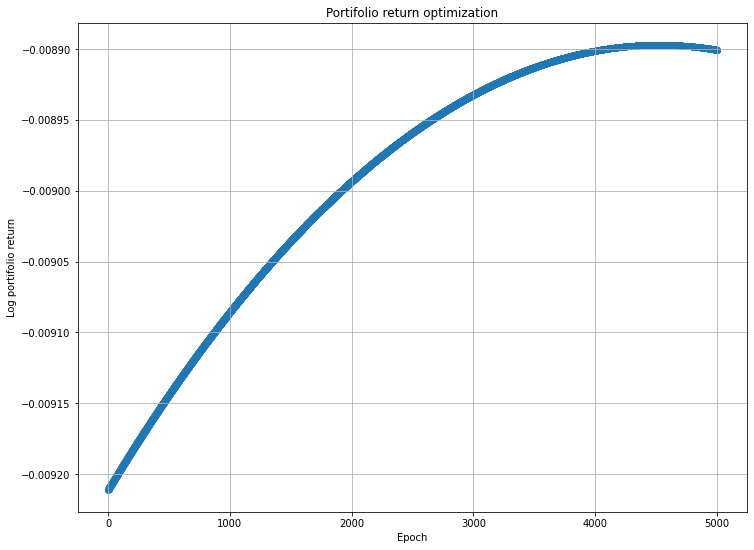

In [15]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

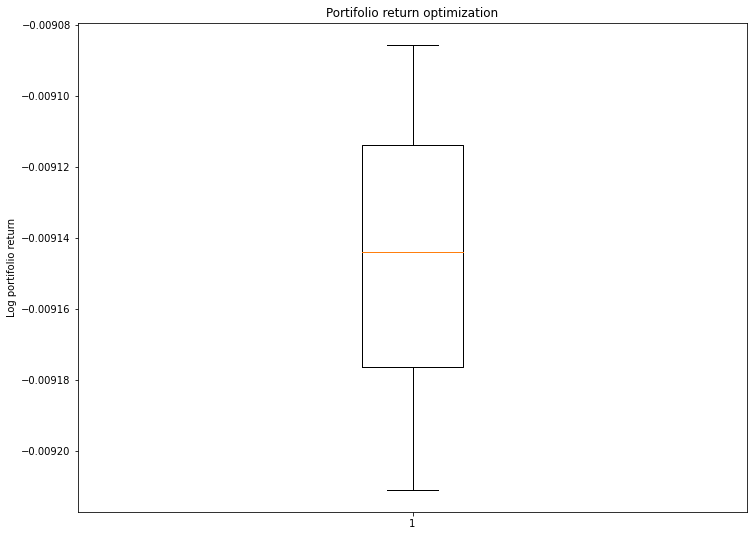

In [231]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.boxplot(return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.show()

## Using scipy to optimize easily and to add constraints

In [12]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 4000 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [13]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [14]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [52]:
time = 90
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i] + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
    
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [48]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69647, 0.28614, 0.22685]])

In [17]:
from scipy.optimize import minimize

In [55]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r)))
    
    opt_iter += 1

In [56]:
sol = minimize(objective, theta0, callback=callback_steps)
sol

i:1, theta i: [-0.06351 0.70841 0.74088], f(theta):1.2131658535421985
i:2, theta i: [-0.20432 0.90021 0.93178], f(theta):0.9978152325831017
i:3, theta i: [-0.52549 1.36168 1.38148], f(theta):0.6731738839743524
i:4, theta i: [-0.91579 1.94000 1.93716], f(theta):0.451484515895554
i:5, theta i: [-1.39522 2.65933 2.62362], f(theta):0.3002525460209777
i:6, theta i: [-1.98102 3.54260 3.46382], f(theta):0.1983528425988593
i:7, theta i: [-2.69483 4.62088 4.48809], f(theta):0.1301370450768914
i:8, theta i: [-3.56019 5.92892 5.72992], f(theta):0.08483774706203423
i:9, theta i: [-4.60438 7.50756 7.22839], f(theta):0.054968658415998156
i:10, theta i: [-5.85825 9.40331 9.02778], f(theta):0.03541244184901504
i:11, theta i: [-7.35715 11.66955 11.17886], f(theta):0.022691391987925764
i:12, theta i: [-9.14152 14.36743 13.73968], f(theta):0.014466088600210095
i:13, theta i: [-11.25767 17.56695 16.77670], f(theta):0.009176830512822358
i:14, theta i: [-13.75844 21.34802 20.36577], f(theta):0.0057930025887

      fun: 0.00033151769537402044
 hess_inv: array([[141944.34195, -214613.46502, -203717.71370],
       [-214613.46502, 324488.78434, 308013.86671],
       [-203717.71370, 308013.86671, 292377.30351]])
      jac: array([0.00001, -0.00000, -0.00001])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([-40.71603, 62.10689, 59.05532])

In [20]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [28]:
np.sum(w_sol, axis=1)/time

array([8.31961, 8.38071, 8.25111, 7.94663, 8.36792, -8.06084, -7.75736,
       -8.13767, -8.13713, -8.17299])

In [44]:
sum(sum(w_benchmark*r))

190.9346282688151

In [45]:
sum(sum(w_sol*r))

22450.27196617353

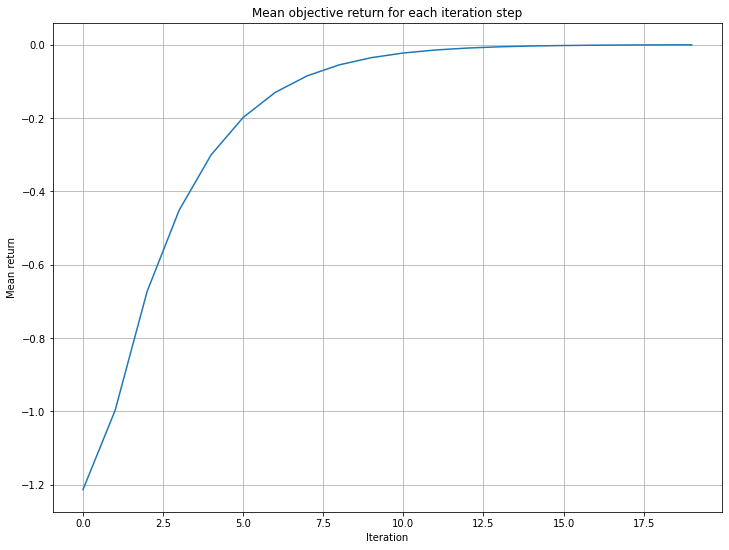

In [68]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.grid()
plt.show()

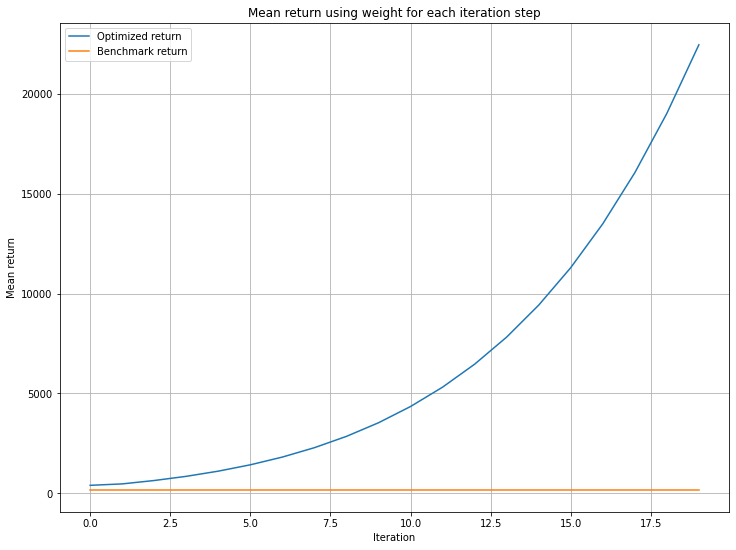

In [70]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [sum(sum(w_benchmark*r))]*len(x), label='Benchmark return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

## Using real data

### Training

In [2]:
lreturn = pd.read_csv('monthly_lagged_return.csv')
mcap = pd.read_csv('monthly_market_cap.csv')
book_to_mkt_ratio = pd.read_csv('monthly_book_to_mkt_ratio.csv')
monthly_return = pd.read_csv('monthly_return.csv')
lreturn.fillna(method='bfill', inplace=True)
mcap.fillna(method='bfill', inplace=True)
book_to_mkt_ratio.fillna(method='bfill', inplace=True)
monthly_return.fillna(method='bfill', inplace=True)

In [3]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)

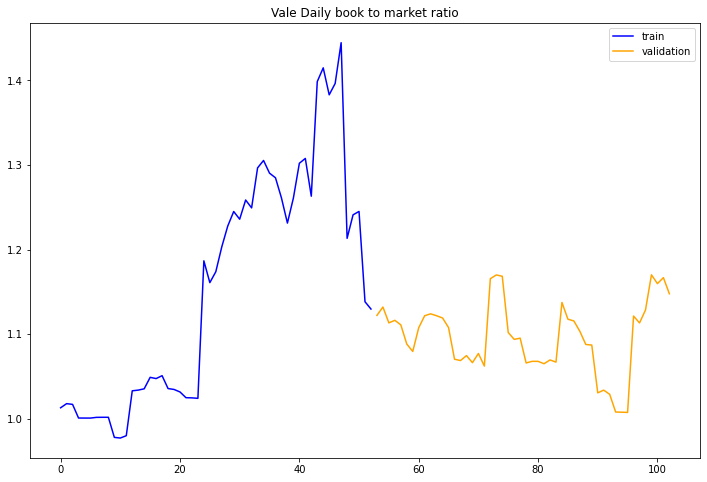

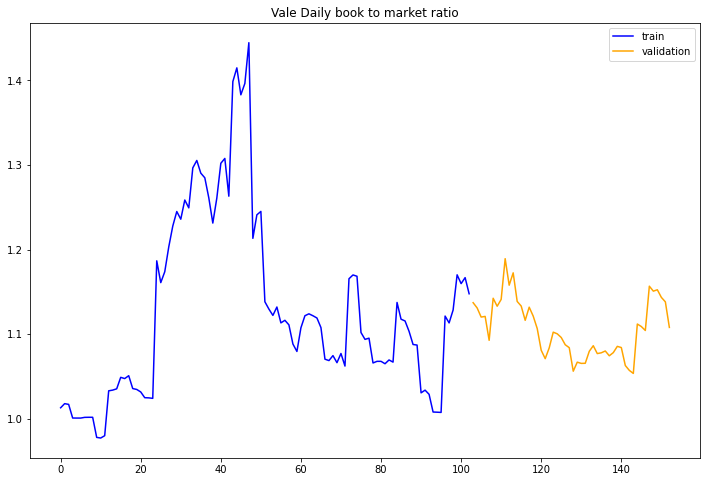

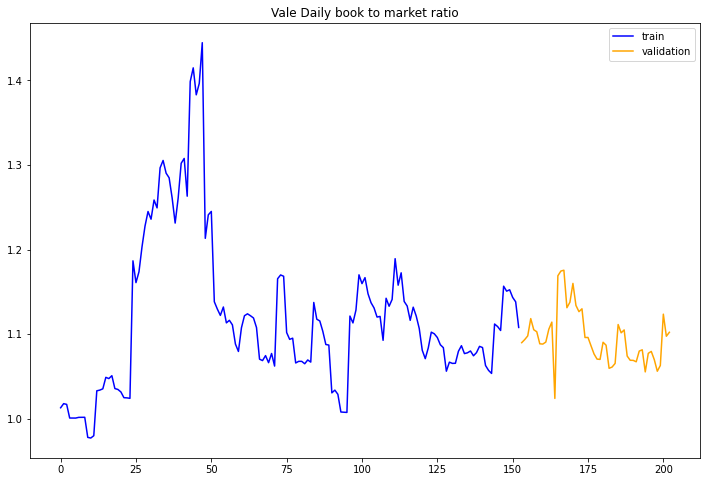

In [4]:
for train, val in splits.split(book_to_mkt_ratio):
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    val_btm = book_to_mkt_ratio.loc[val]
    val_me = mcap.loc[val]
    val_mom = lreturn.loc[val]
    
    test_return = monthly_return.loc[val]

    plt.figure(figsize=(12,8))
    plt.title("Vale Daily book to market ratio")
    plt.ticklabel_format(style='plain')
    train_btm['VALE3'].plot(c='blue', label='train')
    val_btm['VALE3'].plot(c='orange', label='validation')
    plt.legend()
    # plt.grid()
    plt.show()

In [5]:
list(train_me.columns)

['ABCB4',
 'ABRE11',
 'AEDU3',
 'AELP3',
 'AGEN11',
 'AGRO3',
 'ALLL3',
 'ALPA4',
 'ALSC3',
 'AMAR3',
 'AMBV3',
 'AMBV4',
 'AMIL3',
 'ARZZ3',
 'AUTM3',
 'BAZA3',
 'BBAS3',
 'BBDC3',
 'BBDC4',
 'BBRK3',
 'BEEF3',
 'BEMA3',
 'BHGR3',
 'BICB4',
 'BISA3',
 'BOBR4',
 'BPHA3',
 'BPNM4',
 'BRAP4',
 'BRFS3',
 'BRIN3',
 'BRKM5',
 'BRML3',
 'BRPR3',
 'BRSR6',
 'BRTO3',
 'BRTO4',
 'BTOW3',
 'BTTL4',
 'BVMF3',
 'CARD3',
 'CCIM3',
 'CCPR3',
 'CCRO3',
 'CESP6',
 'CGAS3',
 'CGAS5',
 'CIEL3',
 'CLSC6',
 'CMIG3',
 'CMIG4',
 'CNFB4',
 'COCE3',
 'COCE5',
 'CPFE3',
 'CPLE3',
 'CPLE6',
 'CRDE3',
 'CREM3',
 'CRUZ3',
 'CSAN3',
 'CSMG3',
 'CSNA3',
 'CTAX3',
 'CTAX4',
 'CTIP3',
 'CTNM4',
 'CYRE3',
 'CZLT11',
 'CZRS4',
 'DAGB11',
 'DASA3',
 'DAYC4',
 'DIRR3',
 'DROG3',
 'DTEX3',
 'ECOR3',
 'ELET3',
 'ELET6',
 'ELPL4',
 'EMBR3',
 'ENBR3',
 'EQTL3',
 'ESTC3',
 'ESTR4',
 'ETER3',
 'EUCA4',
 'EVEN3',
 'EZTC3',
 'FESA4',
 'FFTL4',
 'FHER3',
 'FIBR3',
 'FJTA4',
 'FLRY3',
 'FRAS4',
 'FRIO3',
 'FTRX4',
 'GETI3',
 'GETI

In [6]:
def create_characteristics(me_df, mom_df, btm_df, return_df):
    firm_characteristics = defaultdict(list)

    stocks_names = list(return_df.columns)

    time = return_df.shape[0] 
    number_of_stocks = len(stocks_names)
    r = np.empty(shape=(number_of_stocks, time))
    epsilon = 1e-10

    for i, name in enumerate(stocks_names):
        me = me_df.get(name)
        mom = mom_df.get(name)
        btm = btm_df.get(name)
        mr = return_df.get(name) 

        firm_characteristics[(i,'me')] = me.fillna(method='bfill')
        firm_characteristics[(i,'btm')] = btm.fillna(method='bfill')
        firm_characteristics[(i,'mom')]= mom.fillna(method='bfill')

        r[i] = mr.fillna(method='bfill')

    print("Created firm characteristics matrix")
    firm_characteristics = pd.DataFrame(firm_characteristics)
    #Normalize firm characteristics for each stock
    sum_df = firm_characteristics.T.loc[(slice(None), "me"), :].sum()
    firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
    firm_characteristics.T.loc[(slice(None), "me"), :] /= (sum_df + epsilon)

    sum_df = firm_characteristics.T.loc[(slice(None), "btm"), :].sum()
    firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
    firm_characteristics.T.loc[(slice(None), "btm"), :] /= (sum_df + epsilon)


    sum_df = firm_characteristics.T.loc[(slice(None), "mom"), :].sum()
    firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
    firm_characteristics.T.loc[(slice(None), "mom"), :] /= (sum_df + epsilon)

    print("Normalized firm characteristics")
    return firm_characteristics, r, time, number_of_stocks

In [7]:
firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return)

Created firm characteristics matrix
Normalized firm characteristics


In [16]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
# w_benchmark = np.empty(shape=(number_of_stocks, time))
# epsilon=1e-5
# for t in range(time):
#     positive_returns = (r[:,t]-min(r[:,t]))+epsilon
#     w_benchmark[:,t] = positive_returns/sum(positive_returns)

w_benchmark = np.ones(shape=(number_of_stocks, time))
w_benchmark *= 1/number_of_stocks

In [17]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [18]:
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i].copy() + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [19]:
def constraint(theta):
    w_sol = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    mean_w = np.sum(w_sol, axis=1)/time
    return mean_w

cons = [{"type" : "ineq", "fun" : constraint}]

In [20]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69646919, 0.28613933, 0.22685145]])

In [21]:
from scipy.optimize import minimize, differential_evolution

In [22]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r)))
    
    opt_iter += 1

In [23]:
# sol = minimize(objective, theta0, callback=callback_steps, method='COBYLA', constraints=cons)
sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
sol

i:1, theta i: [0.6949186  0.26826446 0.1457198 ], f(theta):62.41281837874514
i:2, theta i: [0.67603156 0.04907454 0.09424511], f(theta):62.36033481516201
i:3, theta i: [ 0.6220744  -0.51076812  0.02202199], f(theta):62.2814218283303
i:4, theta i: [ 0.53723038 -1.29887107 -0.00871362], f(theta):62.21518656132013
i:5, theta i: [ 0.39497805 -2.51523366  0.02988959], f(theta):62.13348063805872
i:6, theta i: [ 0.23901108 -3.69778301  0.05326578], f(theta):62.09690083412811
i:7, theta i: [ 0.06857212 -4.85817407  0.07100839], f(theta):62.080035076227254
i:8, theta i: [-0.08542939 -5.79065868  0.07847332], f(theta):62.0739166279842
i:9, theta i: [-0.21826702 -6.48691767  0.07806037], f(theta):62.07159003350922
i:10, theta i: [-0.33314672 -6.97857416  0.07334297], f(theta):62.07048500430242
i:11, theta i: [-0.44351557 -7.32570481  0.066785  ], f(theta):62.06968186260378
i:12, theta i: [-0.59224814 -7.62951842  0.05821458], f(theta):62.06861437889531
i:13, theta i: [-0.81832419 -7.90244543  0.0

      fun: 61.90130119045068
 hess_inv: array([[ 1.33692223e+03, -2.79575408e+01, -2.94980050e-01],
       [-2.79575408e+01,  2.51593332e+02, -4.53470359e-01],
       [-2.94980050e-01, -4.53470359e-01,  2.25948830e-01]])
      jac: array([-1.43051147e-06,  9.53674316e-07, -3.33786011e-06])
  message: 'Optimization terminated successfully.'
     nfev: 136
      nit: 28
     njev: 34
   status: 0
  success: True
        x: array([-23.25088246,  -6.27481997,   0.07042797])

In [24]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [25]:
np.sum(w_sol, axis=1)/time

array([ 4.27097803e-03,  4.29506465e-03,  4.21142839e-03,  4.42847737e-03,
        4.29950247e-03,  4.47381007e-03,  4.38863053e-03,  4.42671426e-03,
        4.34244023e-03,  4.22617706e-03,  2.85032630e-03,  2.85119560e-03,
        3.81897293e-03,  4.26333906e-03,  4.26096290e-03,  4.45354462e-03,
        3.41933176e-03,  2.76648294e-03,  2.77068529e-03,  4.27818902e-03,
        4.30134059e-03,  4.38632652e-03,  4.36814821e-03,  4.10509829e-03,
        4.14154801e-03,  4.43017663e-03,  4.30969134e-03,  4.21451690e-03,
        4.26882869e-03,  4.37090818e-03,  4.38517249e-03,  4.27062673e-03,
        4.26449388e-03,  4.26685067e-03,  4.41099242e-03,  4.05522183e-03,
        4.06977018e-03,  3.54025184e-03,  4.49368039e-03,  1.66165632e-03,
        4.37062575e-03,  4.27973742e-03,  4.34771682e-03,  4.22599871e-03,
        4.19802766e-03,  4.32795782e-03,  4.34013298e-03,  1.95446344e-03,
        4.41108476e-03,  3.87739800e-03,  3.87948073e-03,  4.43558989e-03,
        4.40474061e-03,  

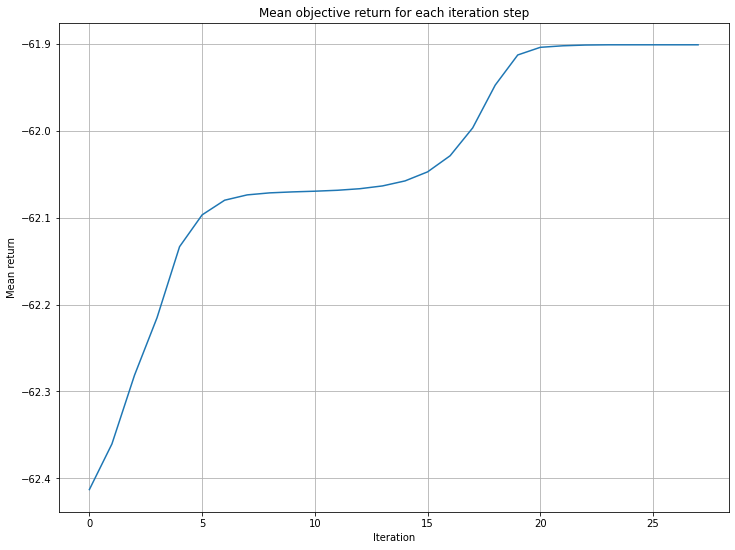

In [26]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

In [27]:
benchmark_mean_return = sum(sum(w_benchmark*r))

# Equally diveded weights for each stock
uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))

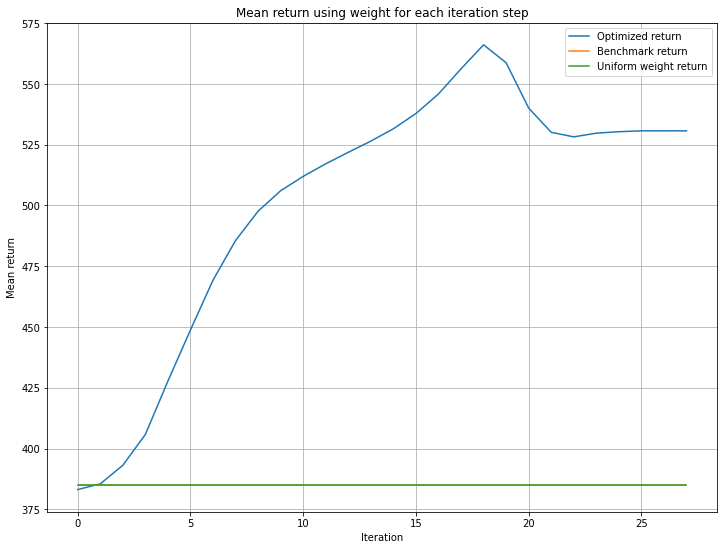

In [28]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [benchmark_mean_return]*len(x), label='Benchmark return')
plt.plot(x, [uniform_weighted_return]*len(x), label='Uniform weight return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

### Testing

In [141]:
sol_theta = sol.x
firm_characteristics_val, r_val, time_val, number_of_stocks = create_characteristics(val_me, val_mom, val_btm, test_return)
firm_characteristics_val.fillna(method='ffill', inplace=True)

#### CREATE BENCHMARK FOR TESTING
w_benchmark_val = np.empty(shape=(number_of_stocks, time_val))
epsilon=1e-5
for t in range(time_val):
    positive_returns = (r_val[:,t]-min(r_val[:,t]))+epsilon
    w_benchmark_val[:,t] = positive_returns/sum(positive_returns)
    
w_val = np.empty(shape=(number_of_stocks, time_val))

for i in range(number_of_stocks):
    firm_df = firm_characteristics_val[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_val[i] = w_benchmark_val[i] + (1/number_of_stocks)*firms_coeff

Created firm characteristics matrix
Normalized firm characteristics


In [142]:
benchmark_mean_return = sum(sum(w_benchmark_val*r_val))
benchmark_mean_return

381.18393749693354

In [143]:
mean_return = sum(sum(w_val*r_val))
mean_return

386.4309169605893

### Testing and optimizing

In [92]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [94]:
sum(np.sum(w_sol, axis=1)/time)

0.9999999999996554

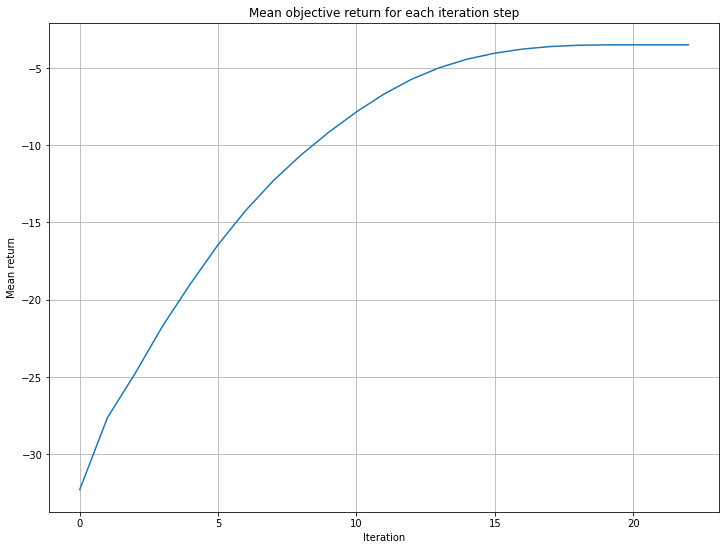

In [95]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

In [97]:
benchmark_mean_return = sum(sum(w_benchmark*r))

# Equally diveded weights for each stock
uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))

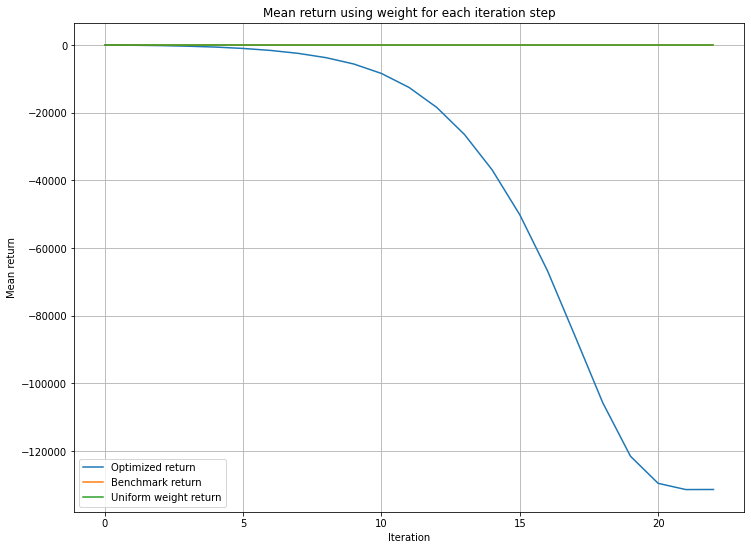

In [98]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [benchmark_mean_return]*len(x), label='Benchmark return')
plt.plot(x, [uniform_weighted_return]*len(x), label='Uniform weight return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

In [144]:
# For each tuple try previous theta and try to optmize
mean_obj_r_tuple = []
mean_r_tuple = []
bench_tuple = []
eq_weighted_tuple = []
return_tuple = []

for i in range(0, test_return.shape[0], 2):
    firm_characteristics_val, r_val, time_val, number_of_stocks = create_characteristics(val_me.iloc[i:i+2], val_mom.iloc[i:i+2], val_btm.iloc[i:i+2], test_return.iloc[i:i+2])
    firm_characteristics_val.fillna(method='ffill', inplace=True)
    
    sol_theta = sol.x
    theta0 = sol_theta
    firm_characteristics = firm_characteristics_val
    r = r_val
    time = time_val

    w_benchmark = np.empty(shape=(number_of_stocks, time))
    epsilon=1e-5
    for t in range(time):
        positive_returns = (r[:,t]-min(r[:,t]))+epsilon
        w_benchmark[:,t] = positive_returns/sum(positive_returns)
    
    opt_iter = 1
    mean_obj_r = []
    mean_r = []
    sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
    mean_obj_r_tuple.append(mean_obj_r)
    mean_r_tuple.append(mean_r)
    
    
    benchmark_mean_return = sum(sum(w_benchmark*r))
    bench_tuple.append(benchmark_mean_return)
    
    # Equally diveded weights for each stock
    uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
    uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))
    eq_weighted_tuple.append(uniform_weighted_return)
    
    sol_theta = sol.x
    w_sol = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    return_tuple.append(sum(sum(w_sol*r)))
    

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [-83.81633265   3.08145557  -7.6132865 ], f(theta):32.29670300267634
i:2, theta i: [-83.1227851    3.15723658 -27.93866206], f(theta):27.644127591297295
i:3, theta i: [-82.38243268   3.2383676  -49.63512763], f(theta):24.780533304768994
i:4, theta i: [-81.08058064   3.38122949 -87.79842664], f(theta):21.689592483010074
i:5, theta i: [ -79.18195282    3.58971725 -143.47223628], f(theta):18.97704619254287
i:6, theta i: [ -76.23670215    3.9132508  -229.85414032], f(theta):16.442163771758835
i:7, theta i: [ -71.8994728     4.38981595 -357.07825958], f(theta):14.220080130353688
i:8, theta i: [ -65.55870949    5.08665809 -543.08546154], f(theta):12.293418279627058
i:9, theta i: [ -56.33947512    6.09996936 -813.54313532], f(theta):10.62943994571219
i:10, theta i: [  -42.72240296     7.5967721  -1213.02425001], f(theta):9.1606090872453
i:11, theta i: [  -22.34463042     9.83680986 -1810.84831788], f(theta):7.84

i:36, theta i: [   901.91433317   1142.88473035 -23894.58491564], f(theta):77.84674601938757
i:37, theta i: [   900.36125993   1150.33787777 -23890.36869333], f(theta):77.84142960260355
i:38, theta i: [   898.08289574   1162.71550347 -23883.15048577], f(theta):77.83204275162377
i:39, theta i: [   894.81473744   1181.83226163 -23871.48682104], f(theta):77.81606365249662
i:40, theta i: [   890.57730977   1210.10846789 -23853.28868882], f(theta):77.78951530280197
i:41, theta i: [   885.84352539   1248.14774818 -23827.05549949], f(theta):77.74448073386017
i:42, theta i: [   880.95463698   1296.76117876 -23790.52621529], f(theta):77.665121707788
i:43, theta i: [   875.6953398    1359.13140972 -23738.40077062], f(theta):77.52116232831646
i:44, theta i: [   869.63168102   1444.2410195  -23658.78807264], f(theta):77.25709245669819
i:45, theta i: [   862.09508059   1565.77717287 -23530.59252929], f(theta):76.77387780948155
i:46, theta i: [   852.21252807   1743.31949553 -23316.94906067], f(thet

i:12, theta i: [   415.63278825 -19078.40325463  -5831.33991312], f(theta):92.23497384588298
i:13, theta i: [   416.8233729  -19077.79380582  -5833.08514141], f(theta):92.2276987840848
i:14, theta i: [   418.28699259 -19077.11312136  -5835.34842447], f(theta):92.2139440980481
i:15, theta i: [   420.25209312 -19076.31170522  -5838.58048596], f(theta):92.18785432984974
i:16, theta i: [   423.10674357 -19075.33136587  -5843.59159551], f(theta):92.13897665440548
i:17, theta i: [   427.35306425 -19074.21349489  -5851.63056811], f(theta):92.04873596692963
i:18, theta i: [   433.80763538 -19073.14648296  -5864.93647197], f(theta):91.88677760066643
i:19, theta i: [   443.5362744  -19072.79815436  -5887.15690053], f(theta):91.60714743753968
i:20, theta i: [   457.54394566 -19074.9408472   -5923.69454757], f(theta):91.1438536364093
i:21, theta i: [   475.77732273 -19083.34737934  -5980.90765351], f(theta):90.3945505905183
i:22, theta i: [   496.01480087 -19104.32290905  -6064.42019683], f(theta)

i:15, theta i: [  1749.33987007 -16179.21608273  -6461.8220144 ], f(theta):45470.86529076499
i:16, theta i: [  1766.02909327 -16153.22236225  -6453.03601861], f(theta):44311.499892467364
i:17, theta i: [  1773.80182089 -16112.77373213  -6444.07966419], f(theta):42233.82258703611
i:18, theta i: [  1772.15687423 -16107.46372535  -6432.01039945], f(theta):38579.782498575245
i:19, theta i: [  1728.6328171  -16101.79836763  -6421.90727732], f(theta):32262.01765983305
i:20, theta i: [  1603.11997739 -16176.09054681  -6412.12245211], f(theta):22286.563614723756
i:21, theta i: [  1389.89077113 -16322.6715644   -6405.64802344], f(theta):13319.263056051434
i:22, theta i: [  1159.71548057 -16487.35005008  -6401.2881517 ], f(theta):8268.94008059751
i:23, theta i: [   886.88620822 -16684.89014829  -6397.04123989], f(theta):5074.0834684274605
i:24, theta i: [   582.5680775  -16906.38827833  -6392.71119564], f(theta):3209.6401430726196
i:25, theta i: [   265.2509127  -17138.30316206  -6388.37511771],

i:12, theta i: [6145102.87778176 6381609.94897161 1954842.86706127], f(theta):1.0527822198564358
i:13, theta i: [6145017.11117556 6381602.13717659 1955147.00697775], f(theta):0.8330125684718562
i:14, theta i: [6144921.91016542 6381593.46610038 1955484.60265059], f(theta):0.7029254333479865
i:15, theta i: [6144809.84646767 6381583.25914208 1955881.99564586], f(theta):0.6215686229802594
i:16, theta i: [6144685.91418689 6381571.97116514 1956321.47623819], f(theta):0.5739737705470564
i:17, theta i: [6144542.16422823 6381558.87816254 1956831.2329766 ], f(theta):0.5446947268173705
i:18, theta i: [6144376.42562696 6381543.78239497 1957418.96441654], f(theta):0.5269911746288333
i:19, theta i: [6144201.58891641 6381527.85795545 1958038.95897467], f(theta):0.5170340849383923
i:20, theta i: [6143994.28643762 6381508.97647581 1958774.08152814], f(theta):0.5106743337715296
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [6143770.28643845 6381342.30980976 1960114.08

In [146]:
x = range(len(return_tuple))

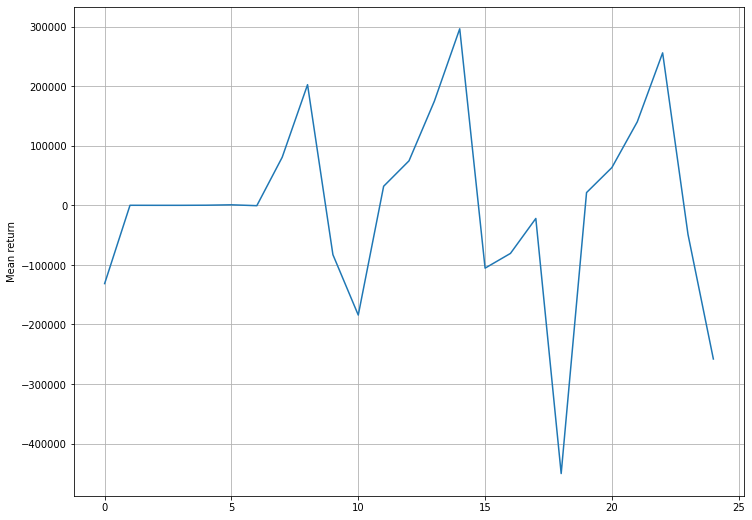

In [149]:
x = range(len(return_tuple))
plt.figure(figsize=(12,9))
plt.plot(x,return_tuple)
# plt.xlabel('Iteration')
plt.ylabel('Mean return')
# plt.legend()
plt.grid()
plt.show()

In [151]:
sum(return_tuple)/len(return_tuple)

-814.2736236383219

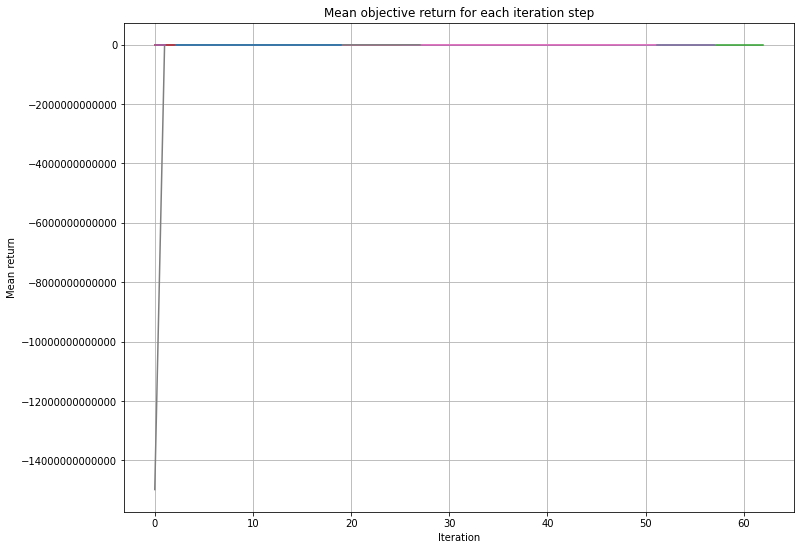

In [157]:
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
for mean_obj_r in mean_obj_r_tuple:
    x = range(len(mean_obj_r))
    plt.plot(x, mean_obj_r)

plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

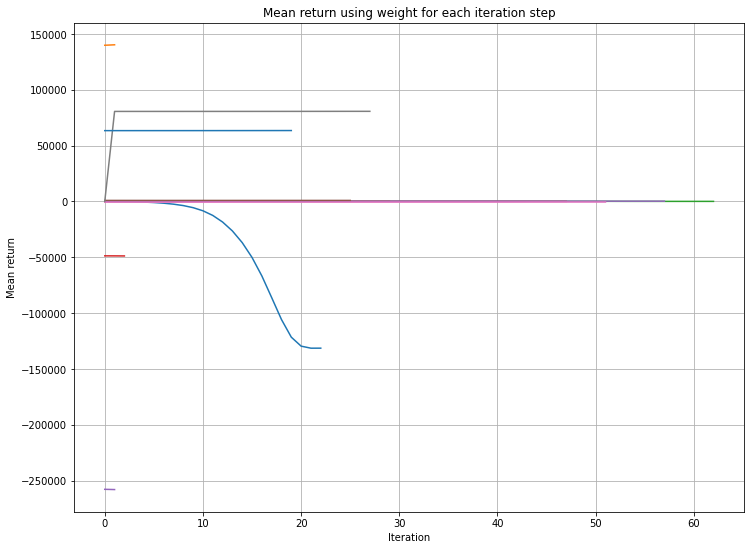

In [158]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for mean_r in mean_r_tuple:
    x = range(len(mean_r))
    plt.plot(x, mean_r)

plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

## Training with k-fold (k=10)

In [43]:
lreturn = pd.read_csv('monthly_lagged_return.csv')
mcap = pd.read_csv('monthly_market_cap.csv')
book_to_mkt_ratio = pd.read_csv('monthly_book_to_mkt_ratio.csv')
monthly_return = pd.read_csv('monthly_return.csv')
lreturn.fillna(method='bfill', inplace=True)
lreturn.fillna(method='ffill', inplace=True)
mcap.fillna(method='bfill', inplace=True)
mcap.fillna(method='ffill', inplace=True)
book_to_mkt_ratio.fillna(method='bfill', inplace=True)
book_to_mkt_ratio.fillna(method='ffill', inplace=True)
monthly_return.fillna(method='bfill', inplace=True)
monthly_return.fillna(method='ffill', inplace=True)

In [97]:
from sklearn.model_selection import TimeSeriesSplit
num_folds = 10
splits = TimeSeriesSplit(n_splits=num_folds)

In [45]:
def create_characteristics(me_df, mom_df, btm_df, return_df):
    firm_characteristics = defaultdict(list)

    stocks_names = list(return_df.columns)

    time = return_df.shape[0] 
    number_of_stocks = len(stocks_names)
    r = np.empty(shape=(number_of_stocks, time))
    epsilon = 1e-10

    for i, name in enumerate(stocks_names):
        me = me_df.get(name)
        mom = mom_df.get(name)
        btm = btm_df.get(name)
        mr = return_df.get(name) 

        firm_characteristics[(i,'me')] = me.fillna(method='bfill')
        firm_characteristics[(i,'btm')] = btm.fillna(method='bfill')
        firm_characteristics[(i,'mom')]= mom.fillna(method='bfill')

        r[i] = mr.fillna(method='bfill')

    print("Created firm characteristics matrix")
    firm_characteristics = pd.DataFrame(firm_characteristics)
    #Normalize firm characteristics for each stock
    sum_df = firm_characteristics.T.loc[(slice(None), "me"), :].sum()
    firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
    firm_characteristics.T.loc[(slice(None), "me"), :] /= (sum_df + epsilon)

    sum_df = firm_characteristics.T.loc[(slice(None), "btm"), :].sum()
    firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
    firm_characteristics.T.loc[(slice(None), "btm"), :] /= (sum_df + epsilon)


    sum_df = firm_characteristics.T.loc[(slice(None), "mom"), :].sum()
    firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
    firm_characteristics.T.loc[(slice(None), "mom"), :] /= (sum_df + epsilon)

    print("Normalized firm characteristics")
    return firm_characteristics, r, time, number_of_stocks

In [46]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [47]:
def optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark):

    def objective(theta): 
        w = np.empty(shape=(number_of_stocks, time))
        for i in range(number_of_stocks):
            w[i] = w_benchmark[i].copy() + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
        return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time
    
    opt_iter = 1
    mean_obj_r = []
    mean_r = []
    
    def callback_steps(thetaI):
        global opt_iter
        print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
        mean_obj_r.append(-objective(thetaI))

        w_iter = np.empty(shape=(number_of_stocks, time))
        for i in range(number_of_stocks):
            w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
        mean_r.append(sum(sum(w_iter*r)))

        opt_iter += 1
    
    sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
    return sol, mean_obj_r, mean_r

In [48]:
mean_obj_r_fold = []
mean_r_fold = []
benchmark_r_fold = []
eq_weighetd_r_fold = []
theta_fold = []
test_r_fold = []
benchmark_test_r_fold =[]
eq_weighetd_test_r_fold = []
benchmark_weights_fold = []

for train, test in splits.split(book_to_mkt_ratio):
    np.random.seed(123)
    theta0 = np.random.rand(1, 3)
    
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    test_btm = book_to_mkt_ratio.loc[test]
    test_me = mcap.loc[test]
    test_mom = lreturn.loc[test]
    
    test_return = monthly_return.loc[test]
    
    #### TRAINING CHARACTERISTICS
    firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return)
    
    # Creating a weight from a benchmark portifolio using uniform weighted    
    w_benchmark = np.ones(shape=(number_of_stocks, time))
    w_benchmark *= 1/number_of_stocks
    
    benchmark_weights_fold.append(w_benchmark)
    
    ### CREATING RETURNS TO COMPARE
    benchmark_mean_return = sum(sum(w_benchmark*r))
    benchmark_r_fold.append(benchmark_mean_return)
    
    # Equally diveded weights for each stock
    uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
    uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))
    eq_weighetd_r_fold.append(uniform_weighted_return)
    
    opt_iter = 1
    sol, mean_obj_r, mean_r = optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark)
    sol_theta = sol.x
    
    ### SAVING PARAMETERS TO LOOKUP AFTER
    mean_r_fold.append(mean_r)
    mean_obj_r_fold.append(mean_obj_r)
    theta_fold.append(sol_theta)
    
    #### TESTING CHARACTERISTICS
    firm_characteristics_test, r_test, time_test, number_of_stocks = create_characteristics(test_me, test_mom, test_btm, test_return)
    firm_characteristics_test.fillna(method='ffill', inplace=True)

    #### CREATE BENCHMARK FOR TESTING
    w_benchmark_test = np.empty(shape=(number_of_stocks, time_test))
    w_benchmark_test *= 1/number_of_stocks

    benchmark_test_r = sum(sum(w_benchmark_test*r_test))
    benchmark_test_r_fold.append(benchmark_test_r)
    
    uniform_weighted_test_stocks = np.ones_like(w_benchmark_test)*(1/number_of_stocks)
    uniform_weighted_test_r = sum(sum(uniform_weighted_test_stocks*r_test))
    eq_weighetd_test_r_fold.append(uniform_weighted_test_r)
    
    
    ### CREATE TEST WEIGHT AND FIND ITS RETURN
    w_test = np.empty(shape=(number_of_stocks, time_test))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics_test[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_test[i] = w_benchmark_test[i] + (1/number_of_stocks)*firms_coeff
    
    
    test_r = sum(sum(w_test*r_test))
    test_r_fold.append(test_r)
    

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [ 0.69033811  0.23553695 -0.17114022], f(theta):61.19658651882002
i:2, theta i: [ 0.66700189  0.04302247 -0.16304128], f(theta):61.161304550873645
i:3, theta i: [ 0.6097152  -0.37173921 -0.14868662], f(theta):61.09891134025038
i:4, theta i: [ 0.46004647 -1.33227921 -0.12365424], f(theta):61.00473873137434
i:5, theta i: [ 0.25866826 -2.47499163 -0.10931809], f(theta):60.94640425867629
i:6, theta i: [ 0.04768979 -3.54073526 -0.11070944], f(theta):60.91942427424157
i:7, theta i: [-0.1655435  -4.49970817 -0.11945712], f(theta):60.907780511349145
i:8, theta i: [-0.34162651 -5.18458326 -0.12699941], f(theta):60.904012967400455
i:9, theta i: [-0.4728235  -5.59457262 -0.13050739], f(theta):60.90270536887287
i:10, theta i: [-0.61815777 -5.93282399 -0.13189911], f(theta):60.90151448550031
i:11, theta i: [-0.8496678  -6.32605334 -0.13178068], f(theta):60.89948552917247
i:12, theta i: [-1.22497492 -6.7940794  -0.1298

i:15, theta i: [-3.97479174 -9.48518474 -0.23580796], f(theta):62.2803054233093
i:16, theta i: [ -6.98895628 -11.37368773  -0.25192406], f(theta):62.257337433464876
i:17, theta i: [-10.14258899 -12.73366542  -0.2826886 ], f(theta):62.23877974620993
i:18, theta i: [-13.00112127 -13.11004965  -0.3197308 ], f(theta):62.21997178290156
i:19, theta i: [-16.43696886 -12.17109995  -0.37031724], f(theta):62.188813824783246
i:20, theta i: [-20.65191323  -8.82563098  -0.43199204], f(theta):62.13919495496823
i:21, theta i: [-22.57127035  -5.84950648  -0.44615217], f(theta):62.115965711859985
i:22, theta i: [-22.70523335  -4.99598526  -0.39826425], f(theta):62.108477916858625
i:23, theta i: [-22.25326207  -5.34002722  -0.29188383], f(theta):62.10150840739507
i:24, theta i: [-22.60446763  -5.30627799  -0.28335105], f(theta):62.101332346876575
i:25, theta i: [-22.99489473  -5.32133193  -0.28109215], f(theta):62.10126777036142
i:26, theta i: [-23.05486654  -5.33044568  -0.28206669], f(theta):62.101265

i:25, theta i: [-25.14405458  -6.05201965   0.06308841], f(theta):61.999416183991364
i:26, theta i: [-25.14332556  -6.05201779   0.06309126], f(theta):61.99941618376416
i:27, theta i: [-25.1431099   -6.05206645   0.0630924 ], f(theta):61.99941618373815
i:28, theta i: [-25.14310797  -6.05206679   0.06309241], f(theta):61.99941618373813
i:29, theta i: [-25.14310796  -6.05206679   0.06309241], f(theta):61.99941618373813
Created firm characteristics matrix
Normalized firm characteristics
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [0.69349171 0.25240504 0.07280478], f(theta):62.37968209492987
i:2, theta i: [0.67455319 0.03747359 0.06210824], f(theta):62.33855587498387
i:3, theta i: [ 0.62784648 -0.42828591  0.0565027 ], f(theta):62.26658336017103
i:4, theta i: [ 0.50479663 -1.51286544  0.0585679 ], f(theta):62.15950615272051
i:5, theta i: [ 0.34879014 -2.72417133  0.06442872], f(theta):62.09722188450992
i:6, theta i: [ 0.17203646 -3.95192773  0.0670590

In [49]:
colors ={
    0:'black',
    1:'blue',
    2:'coral',
    3:'magenta',
    4:'grey',
    5:'violet',
    6:'brown',
    7:'red',
    8:'salmon',
    9:'green'
}

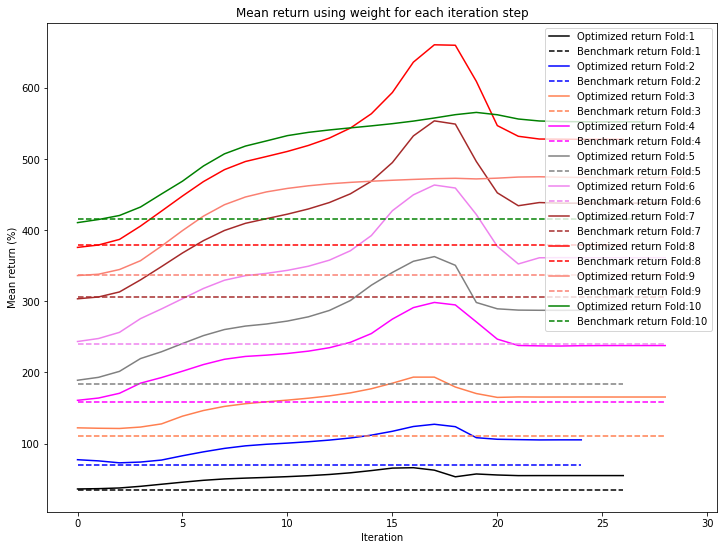

In [50]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_r in enumerate(mean_r_fold):
    x = range(len(mean_r))
    plt.plot(x, mean_r, label=f'Optimized return Fold:{fold+1}', c=colors[fold])
    plt.plot(x, [benchmark_r_fold[fold]]*len(mean_r), label=f'Benchmark return Fold:{fold+1}', c=colors[fold], linestyle='dashed')
#     plt.plot(x, [eq_weighetd_r_fold[fold]]*len(mean_r), label=f'Equally weighted return Fold:{fold+1}', c=colors[fold], marker='.')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return (%)')
    plt.legend()
    plt.grid()
plt.show()

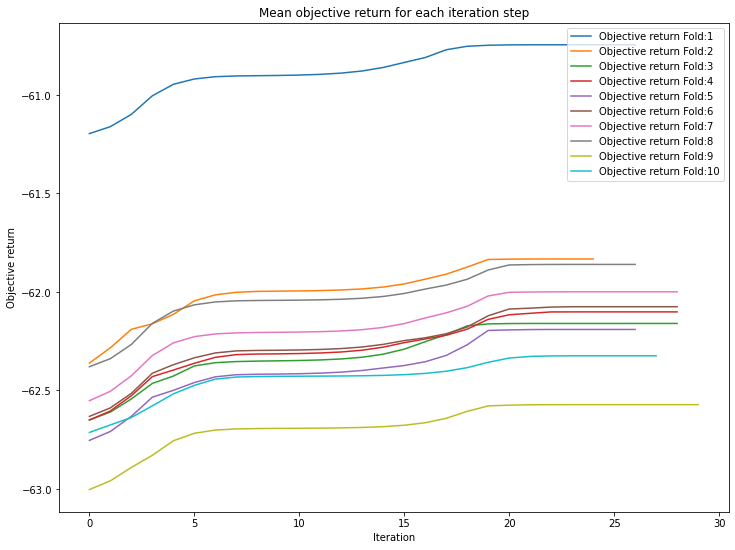

In [51]:
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
for fold, mean_obj_r in enumerate(mean_obj_r_fold):
    x = range(len(mean_obj_r))
    plt.plot(x, mean_obj_r, label=f'Objective return Fold:{fold+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Objective return')
    plt.legend()
    plt.grid()
plt.show()

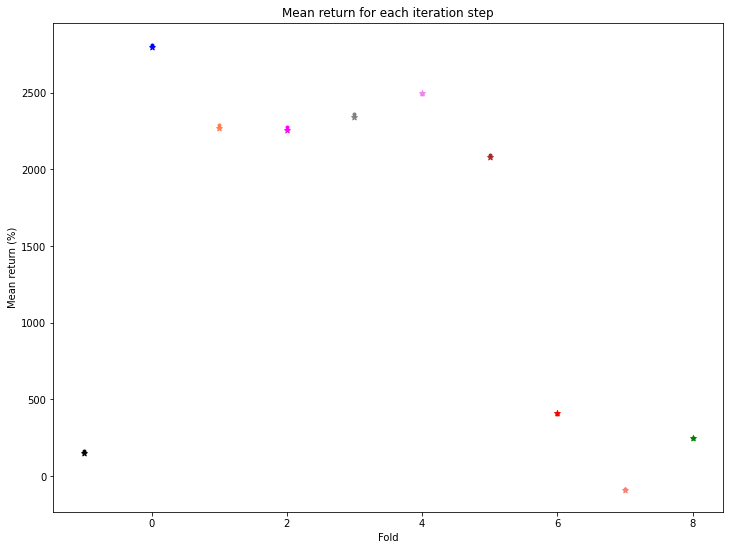

In [104]:
plt.figure(figsize=(12,9))
plt.title("Mean return for each iteration step")
for fold, mean_test_r in enumerate(test_r_fold):
    x = range(fold-1, fold)
    plt.scatter(x, mean_test_r, label=f'Optimized test return Fold:{fold+1}', c=colors[fold], marker='.')
    plt.scatter(x, benchmark_test_r_fold[fold], label=f'Benchmark test return Fold:{fold+1}', c=colors[fold], marker='*')
#     plt.plot(x, [eq_weighetd_r_fold[fold]]*len(mean_r), label=f'Equally weighted return Fold:{fold+1}', c=colors[fold], marker='.')
    plt.xlabel('Fold')
    plt.ylabel('Mean return (%)')
#     plt.legend()
    plt.grid()
plt.show()

In [91]:
diff_r = np.array(test_r_fold) - np.array(benchmark_test_r_fold)
diff_r

array([13.85941773, 15.29454329, 18.01381684, 18.65384819, 15.62671711,
       -3.41603055, 13.83213384, -2.04344354,  1.33117412,  0.59833243])

In [100]:
mean_return_above_benchmark = diff_r.sum()/num_folds
mean_return_above_benchmark

9.175050944555672

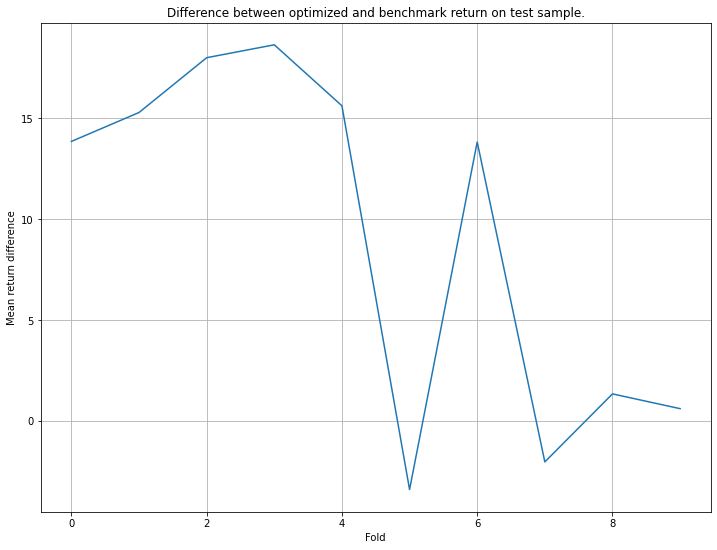

In [107]:
plt.figure(figsize=(12,9))
plt.title("Difference between optimized and benchmark return on test sample.")
x = range(10)
plt.plot(x, diff_r)
plt.xlabel('Fold')
plt.ylabel('Mean return difference')
plt.grid()
plt.show()

### Mean theta over k-fold using all data comparison to benchmark ( It is wrong using all training data as test data )

In [56]:
mean_theta = sum(theta_fold)/len(theta_fold)
mean_theta

array([-21.57578833,  -5.59872898,  -0.11443815])

In [57]:
mom = lreturn
me = mcap
btm = book_to_mkt_ratio
retrn = monthly_return

In [58]:
firm_characteristics, r, time, number_of_stocks = create_characteristics(me, mom, btm, retrn)
firm_characteristics.fillna(method='ffill', inplace=True)

Created firm characteristics matrix
Normalized firm characteristics


In [71]:
w_benchmark = np.ones(shape=(number_of_stocks, time))
w_benchmark *= 1/number_of_stocks
# epsilon=1e-5
# for t in range(time):
#     positive_returns = (r[:,t]-min(r[:,t]))+epsilon
#     w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [72]:
benchmark_mean_return = sum(sum(w_benchmark*r))
benchmark_mean_return

431.25301386744616

In [74]:
w = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = mean_theta.dot(firm_df.T)
    w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

    
mean_r = sum(sum(w*r))
mean_r

558.108012061107

In [85]:
(w<0).sum()

689

In [86]:
(w>0).sum()

50061

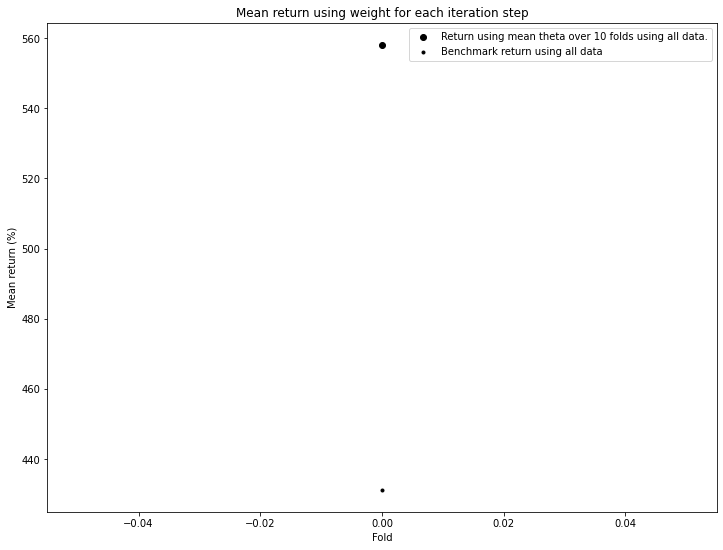

In [76]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")

plt.xlabel('Fold')
plt.ylabel('Mean return (%)')

x = range(0, 1)
plt.scatter(x, mean_r, c='black', label='Return using mean theta over 10 folds using all data.')
plt.scatter(x, benchmark_mean_return, c='black', marker='.', label='Benchmark return using all data')
plt.legend()
plt.show()